# Import Libraries

In [1]:
import pymongo
from textblob import TextBlob
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

## Initializing pymongo and spaCy Stuff

In [ ]:
#pymongo stuff
connection_string = "mongodb://localhost:27017" # Make sure you have mongod running and your senators.archive has been restored with mongorestore
db_name = "senators"

client = pymongo.MongoClient(connection_string)
db = client[db_name]

collection_names = db.list_collection_names()
collection_names1 = list(set(collection_names) - set(['MittRomney.json','RobertMenendez.json','A_Press_info_Senator_2.json','MitchMcconnell.json','A_Press_info_Senator_3.json','A_Press_info_final.json','BernieSanders.json',]))
# Data Cleaning: Used a bunch of loops and print/len functions to see which Collections I wanted to keep // Kept collections where every document had name: "Actual Senator Name" and content: "nonempty content"

## Calculating Subjectivity Scores into DataFrame

In [ ]:
data_dict = {'name': [], 'score': []}
for collection in collection_names1:
    col = db[collection]
    if col.count_documents({}) == 1:
        if len(col.find_one()) == 2:
            docs = col.find_one()['press_releases']
        else:
            docs = list(col.find_one().values())[1:]
    else:
        docs = list(col.find())
        
    for doc in docs:
        cont = [doc[k] for k in doc.keys() if str.lower(k) == 'content' or str.lower(k) == 'excerpt'][0]
        name = [doc[k] for k in doc.keys() if str.lower(k) == 'name'][0]
        blob = TextBlob(cont)
        score = blob.subjectivity
        data_dict['name'].append(name)
        data_dict['score'].append(score)
df = pd.DataFrame(data_dict)# (23620 x 2) DataFrame, col1 is 'name' containing senators' name in "First Last" format, col2 is "score" containing subjectivity score of document (float in [0,1]), each row represents a document

## Saving/Loading DataFrame

In [8]:
df.to_csv('subjectivity_scores.csv')
# df = pd.read_csv('subjectivity_scores.csv') # in case you need to restart kernel -- only use if you have already saved the dataframe

## Merging Scores DataFrame (df) with original Senator Table (senators.csv)

In [3]:
senators = pd.read_csv('senators.csv')

In [5]:
name_dict = {'Mark Warner': 'Warner, Mark',
 'Tedd Budd': 'Budd, Ted',
 'Jon Ossof': 'Ossoff, Jon',
 'Rand Paul': 'Paul, Rand',
 'Dianne Feinstein': 'Feinstein, Dianne',
 'James Lankford': 'Lankford, James',
 'Bob Casey': 'Casey Jr., Robert',
 'Tim Kaine': 'Kaine, Tim',
 'Alex Padilla': 'Padilla, Alex',
 'Chris Van Hollen': 'Van Hollen, Chris',
 'Ted Cruz': 'Cruz, Ted',
 'Michael Bennet': 'Bennet, Michael',
 'Marco Rubio': 'Rubio, Marco',
 'Ben Cardin': 'Cardin, Benjamin',
 'Roger Marshall': 'Marshall, Roger',
 'Elizabeth Warren': 'Warren, Elizabeth'}
# Used to translate from "First Last" format to "Last, First" format // also fixes some spelling discrepancies

new_senators = senators.set_index('Name').loc[list(name_dict.values())] # Subset of senators DataFrame with only the senators resent in name_dict
new_senators.shape

(16, 16)

In [9]:
grouped_df = df.groupby('name').agg({'score': list}).reset_index()
grouped_df.name = grouped_df.name.map(name_dict) # Replaced the Scores DataFrame name values with the values from the original Senators Table
grouped_df.shape

(16, 2)

In [11]:
merged_df = pd.merge(grouped_df, new_senators, left_on='name', right_on='Name', how='inner') # Inner Joined Scores dataframe and Senators Dataframe (subset) by Name
merged_df.shape

(16, 18)

## Plot 1 (Summary Statistics Visualization)

In [13]:
p1_df = merged_df[['name', 'score', 'Party']]
p1_df['mean'] = p1_df.score.apply(statistics.mean) # Adding Mean Scores in a new column
p1_df['variance'] = p1_df.score.apply(statistics.variance) # Adding Variance of Scores in a new column
p1_df = p1_df.sort_values('mean') # Sorting DataFrame by mean
p1_df = p1_df.explode('score') # Separating the score lists into individual row entries
p1_df.score = pd.to_numeric(p1_df.score)
p1_df.shape

/tmp/ipykernel_431/932566888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_df['mean'] = p1_df.score.apply(statistics.mean)
/tmp/ipykernel_431/932566888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_df['variance'] = p1_df.score.apply(statistics.variance)


(23620, 5)

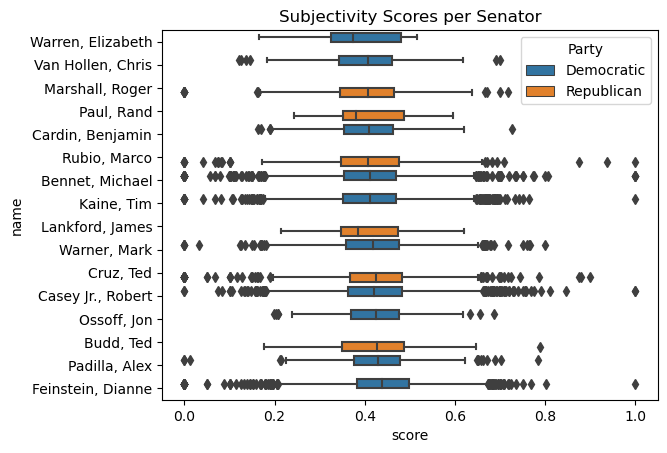

In [14]:
sns.boxplot(data=p1_df, x='score', y='name', hue='Party')
plt.title('Subjectivity Scores per Senator')
plt.show() # Either needs this or plt.savefig() to reset plot
#plt.savefig('boxes.png') #for some reason this got cut out when using savefig but it output the full plot in a jupyter notebook so i used a screenshot

## Plots 2a and 2b (Average Mean/Variance of Subjectivity Scores by Party)

In [15]:
p2_df = merged_df[['name', 'score', 'Party']]
p2_df['mean'] = p2_df.score.apply(statistics.mean) # Adding Mean Scores in a new column
p2_df['variance'] = p2_df.score.apply(statistics.variance) # Adding Variance of Scores in a new column
p2_df = p2_df.groupby('Party').agg({'variance': statistics.mean, 'mean': statistics.mean}).reset_index()
p2_df.shape

/tmp/ipykernel_431/3964001947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2_df['mean'] = p2_df.score.apply(statistics.mean)
/tmp/ipykernel_431/3964001947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2_df['variance'] = p2_df.score.apply(statistics.variance)


(2, 3)

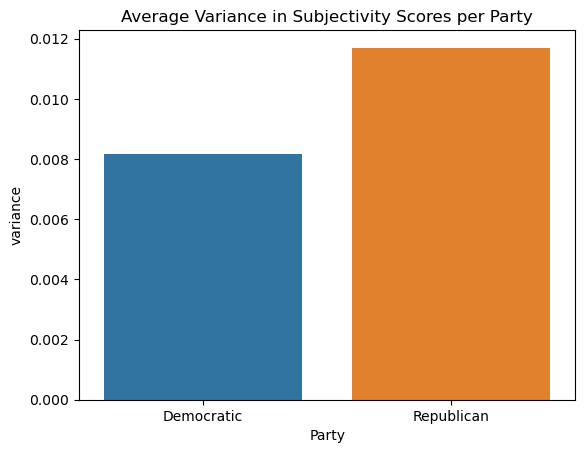

In [16]:
sns.barplot(data=p2_df, x='Party', y='variance')
plt.title('Average Variance in Subjectivity Scores per Party')
plt.show() # Either needs this or plt.savefig() to reset plot
# plt.savefig('var_party.png')

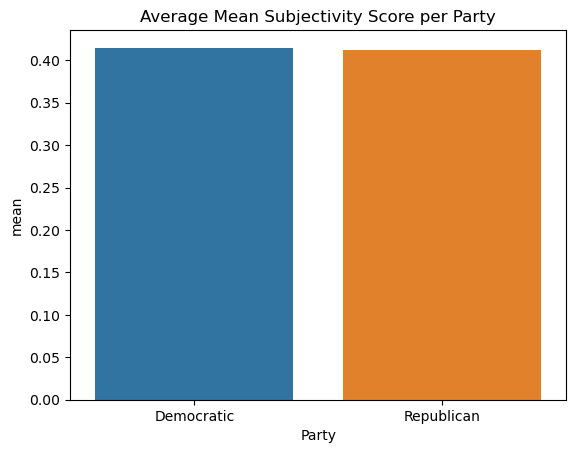

In [17]:
sns.barplot(data=p2_df, x='Party', y='mean')
plt.title('Average Mean Subjectivity Score per Party')
plt.show() # Either needs this or plt.savefig() to reset plot
# plt.savefig('mean_party.png')

## Plot 3 (Average Mean/Variance of Subjectivity Scores vs Age)

In [18]:
p3_df = merged_df[['name', 'score', 'Age']]
p3_df['mean'] = p3_df.score.apply(statistics.mean) # Adding Mean Scores in a new column
p3_df['variance'] = p3_df.score.apply(statistics.variance) # Adding Variance of Scores in a new column
p3_df.shape

/tmp/ipykernel_431/1484546193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_df['mean'] = p3_df.score.apply(statistics.mean)
/tmp/ipykernel_431/1484546193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_df['variance'] = p3_df.score.apply(statistics.variance)


(16, 5)

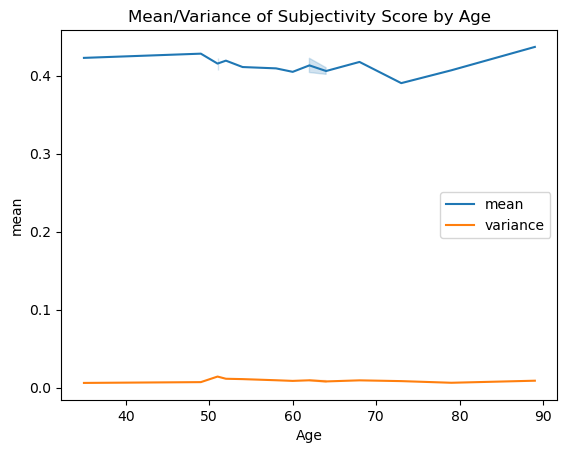

In [14]:
sns.lineplot(data=p3_df, x='Age', y='mean', label='mean')
sns.lineplot(data=p3_df, x='Age', y='variance', label='variance')
plt.title('Mean/Variance of Subjectivity Score by Age')
plt.legend()
plt.show() # Either needs this or plt.savefig() to reset plot
# plt.savefig('mean_var_age.png')